In [1]:
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 transform
from torch.utils.data import DataLoader # 이미지 데이터 로더
import os
import glob

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


In [2]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'

#torch.manual_seed(777)
#if device == 'cuda':
#  torch.cuda.manual_seed_all(777)

In [3]:
if torch.cuda.is_available():
    device = 'cuda' 

torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [4]:
train_path = './train'
test_path = './test'

person_dir = '/person/'
wildboar_dir = '/wildboar/'
waterdeer_dir = '/waterdeer/'

In [5]:
resize_trans = transforms.Compose([
                                   transforms.Resize((128,128)),
                                   transforms.ToTensor()
])

resize_train = torchvision.datasets.ImageFolder(root=train_path, transform=resize_trans)
resize_test = torchvision.datasets.ImageFolder(root=test_path, transform=resize_trans)

In [6]:
resize_train[0][0].shape

torch.Size([3, 128, 128])

In [7]:
import numpy as np
def get_mean_std(dataset):
  meanRGB = [np.mean(image.numpy(), axis=(1,2)) for image,_ in dataset]
  stdRGB = [np.std(image.numpy(), axis=(1,2)) for image,_ in dataset]

  meanR = np.mean([m[0] for m in meanRGB])
  meanG = np.mean([m[1] for m in meanRGB])
  meanB = np.mean([m[2] for m in meanRGB])

  stdR = np.mean([s[0] for s in stdRGB])
  stdG = np.mean([s[1] for s in stdRGB])
  stdB = np.mean([s[2] for s in stdRGB])

  print(meanR, meanG, meanB)
  print(stdR, stdG, stdB)

In [8]:
get_mean_std(resize_train)

0.5619613 0.54894084 0.46700037
0.19371323 0.18722515 0.18210617


In [9]:
get_mean_std(resize_test)

0.5581136 0.53221834 0.4566776
0.19759502 0.19191359 0.1899485


In [10]:
resize_train_mean=[0.5619613, 0.54894084, 0.46700037]
resize_train_std=[0.19371323, 0.18722515, 0.18210617]

resize_test_mean=[0.5581136, 0.53221834, 0.4566776]
resize_test_std=[0.19759502, 0.19191359, 0.1899485]

In [11]:
transform_train = transforms.Compose([
    transforms.Resize((128, 128)), # 이미지 resize
    transforms.RandomCrop(124), # 이미지를 랜덤으로 크롭
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # 이미지 지터링(밝기, 대조, 채비, 색조)
    transforms.RandomHorizontalFlip(p = 1), # p확률로 이미지 좌우반전
    transforms.RandomVerticalFlip(p = 1), # p확률로 상하반전
    transforms.ToTensor(),
    transforms.Normalize(resize_train_mean, resize_train_std)
])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
    transforms.Normalize(resize_test_mean, resize_test_std)
])

trainset = torchvision.datasets.ImageFolder(root=train_path, transform=transform_train)
testset = torchvision.datasets.ImageFolder(root=test_path, transform=transform_test)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=0)

In [12]:
train_path = './train'
test_path = './test'

Dataset_path = './'

person_dir = '/person/'
wildboar_dir = '/wildboar/'
waterdeer_dir = '/waterdeer/'

In [13]:
from torch.utils.data import Dataset, DataLoader # 데이터 커스터마이징
from PIL import Image # PIL = Python Image Library
import cv2 # albumentation transform을 쓰려면 꼭 이 라이브러리를 이용
import tensorflow as tf

class N_Dataset(Dataset):

  def __init__(self, file_path, mode, transform=None):
    self.all_data = sorted(glob.glob(os.path.join(file_path, mode, '*', '*')))
    self.transform = transform

  def __getitem__(self, index):

    if torch.is_tensor(index):        # 인덱스가 tensor 형태일 수 있으니 리스트 형태로 바꿔준다.
       index = index.tolist()

    data_path = self.all_data[index]
    #img = np.array(Image.open(data_path).convert("RGB")) # albumenatation transform을 쓰려면 cv2 라이브러리로 이미지를 읽어야 함
    image=cv2.imread(data_path)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR -> RGB 변환

    # transform 적용
    if self.transform is not None:    
       augmented = self.transform(image=image)
       image = augmented['image'] 

    # 이미지 이름을 활용해 label 부여
    label=[]                                
    if os.path.basename(data_path).startswith("person") == True:
        label = 0
    elif os.path.basename(data_path).startswith("wildboar") == True: 
        label = 1
    else :
        label = 2
    return image, label

  def __len__(self):
    length = len(self.all_data)
    return length

In [14]:
import albumentations
import albumentations.pytorch
from torchvision import transforms # 이미지 데이터 transform
from torch.utils.data import DataLoader # 이미지 데이터 로더

albumentations_train = albumentations.Compose([
                                                
    albumentations.Resize(128, 128),   
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=0.8), # p확률로 이미지 좌우 반전
                          albumentations.RandomRotate90(p=0.8), # p확률로 90도 회전
                          albumentations.VerticalFlip(p=0.8) # p확률로 이미지 상하 반전
    ], p=1),

    albumentations.OneOf([
                          albumentations.MotionBlur(p=0.8), # p확률로 이미지를 흐리게(?) 만들어 줌
                          albumentations.OpticalDistortion(p=0.8), # p확률로 이미지 왜곡
                          albumentations.GaussNoise(p=0.8) # 임의의 noise를 삽입          
    ], p=1),
    # albumentations.Normalize(mean = resize_train_mean, std = resize_train_std),
    albumentations.pytorch.ToTensor()
    
])

albumentations_test = albumentations.Compose([
                                                
    albumentations.Resize(128, 128),
    albumentations.pytorch.ToTensor()
    
])


trainset=N_Dataset(Dataset_path, 'train', transform=albumentations_train)
testset=N_Dataset(Dataset_path, 'test', transform=albumentations_test)

albumentations_train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=0)

albumentations_test_loader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=0)

In [15]:
import torchvision.models.resnet as resnet
import torch.nn as nn
import torch.optim as optim

# 미리 정의
conv1x1=resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock= resnet.BasicBlock

In [16]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=True):
        super(ResNet, self).__init__()
        self.inplanes = 32 # conv1에서 나올 채널의 차원 -> 이미지넷보다 작은 데이터이므로 32로 조정

        # inputs = 3x224x224 -> 3x128x128로 바뀜
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False) # 마찬가지로 전부 사이즈 조정
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 32, layers[0], stride=1) # 3 반복
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2) # 4 반복
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2) # 6 반복
        self.layer4 = self._make_layer(block, 256, layers[3], stride=2) # 3 반복
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1): # planes -> 입력되는 채널 수
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion: 
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        # input [32, 128, 128] -> [C ,H, W]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #x.shape =[32, 64, 64]

        x = self.layer1(x)
        #x.shape =[128, 64, 64]
        x = self.layer2(x)
        #x.shape =[256, 32, 32]
        x = self.layer3(x)
        #x.shape =[512, 16, 16]
        x = self.layer4(x)
        #x.shape =[1024, 8, 8]
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [17]:
resnet50 = ResNet(resnet.Bottleneck, [3, 4, 6, 3], 3, True).to(device) 

In [18]:
class Config:
  def __init__(self, **kwargs):
    for key, value in kwargs.items():
      setattr(self, key, value)

In [19]:
class train_test():
      def __init__(self, config):
        # 파라미터 인자
        self.trainloader = config.trainloader
        self.testloader = config.testloader
        self.model = config.model
        self.device = config.device
        self.optimizer = config.optimizer
        self.criterion = config.criterion
        self.globaliter = config.globaliter
        print(len(self.trainloader))
      def train(self, epochs, log_interval):
          self.model.train()
          for epoch in range(1, epochs + 1 ):  # epochs 루프
              running_loss = 0.0
              #lr_sche.step()
              for i, data in enumerate(self.trainloader, 0): # batch 루프
                  # get the inputs
                  self.globaliter += 1
                  inputs, labels = data # input data, label 분리
                  inputs = inputs.to(self.device)
                  labels = labels.to(self.device)

                  # 가중치 초기화 -> 이전 batch에서 계산되었던 가중치를 0으로 만들고 최적화 진행
                  self.optimizer.zero_grad() 

                  # forward + backward + optimize
                  outputs = self.model(inputs)
                  loss = self.criterion(outputs, labels)
                  loss.backward()
                  self.optimizer.step()
                  running_loss += loss.item()

                  # 30 iteration마다 acc & loss 출력
                  if i % log_interval == log_interval -1 : # i는 1에포크의 iteration
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tlearningLoss: {:.6f}\twhole_loss: {:.6f} '.format(
                        epoch, i*len(inputs), len(self.trainloader.dataset),
                        100. * i*len(inputs) / len(self.trainloader.dataset), 
                        running_loss / log_interval,
                        loss.item()))
                    running_loss = 0.0

                    with train_summary_writer.as_default():  # 텐서보드에 등록하기
                         summary.scalar('loss', loss.item() , step = self.globaliter)

              with torch.no_grad():
                  self.model.eval()
                  correct = 0
                  total = 0
                  test_loss = 0
                  acc = []
                  for k, data in enumerate(self.testloader, 0):
                    images, labels = data
                    images = images.to(self.device)
                    labels = labels.to(self.device)
                    outputs = self.model(images)

                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    test_loss += self.criterion(outputs, labels).item()
                    acc.append(100 * correct/total)

                  print('\nTest set : Average loss:{:.4f}, Accuracy: {}/{}({:.0f}%)\n'.format(
                      test_loss, correct, total, 100 * correct/total
                  ))
                  with test_summary_writer.as_default():  # 텐서보드에 등록하기
                      summary.scalar('loss', test_loss , step = self.globaliter)
                      summary.scalar('accuracy', 100 * correct/total , step = self.globaliter)  
##                      if acc [k] > 60 and acc[k] > acc[k-1]:
#                         torch.save({
#                                     'epoch': epoch,
#                                     'model_state_dict': self.model.state_dict(),
#                                     'optimizer_state_dict': self.optimizer.state_dict(),
#                                     'loss': test_loss
#                                     }, PATH)
                         
      print('Finished Training')

Finished Training


In [20]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [21]:
lr = 0.0025
epochs = 30
optimizer = 'Adam'
dataset = 'train_loader'

In [22]:
config = Config(
    trainloader = train_loader,
    testloader = test_loader,
    model = resnet50,
    device = device,
    optimizer = torch.optim.Adam(resnet50.parameters(), lr=lr),
    criterion= nn.CrossEntropyLoss().to(device),
    globaliter = 0
)

In [39]:
# 타임스탬프
from torch.utils.tensorboard import SummaryWriter
from tensorflow import summary # 텐서보드에 기록하기 위한 함수
import datetime

time_stamp = str(datetime.datetime.now().timestamp())
log_dir = 'runs/resnet' + time_stamp # runs 경로
writer = SummaryWriter(log_dir)

# 텐보 로드
%load_ext tensorboard
     

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [33]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
     

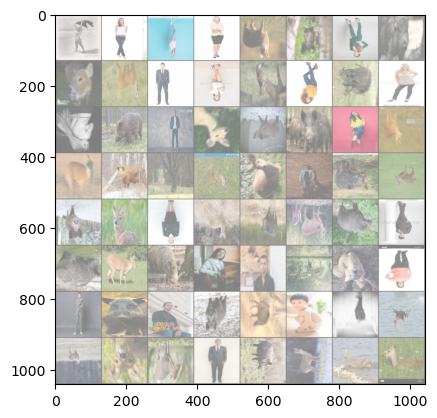

In [34]:
dataiter = iter(albumentations_train_loader)
images, labels = dataiter.__next__()

# 이미지 그리드를 만듭니다.
img_grid = torchvision.utils.make_grid(images)

# 이미지를 보여줍니다.
imshow(img_grid)

# tensorboard에 기록합니다.
writer.add_image('inhovation_images', img_grid)

In [35]:
writer.add_graph(resnet50, images.cuda())
writer.close()


In [36]:
%tensorboard --logdir {log_dir}

ERROR: Failed to launch TensorBoard (exited with 3221225477).

In [37]:
# 데이터 이름을 파라미터로 부여
model_parameter = str(dataset+'batch_size:{:.0f}, lr:{:.5f}'.format(train_loader.batch_size, lr))

# 텐서보드에 올릴 데이터 디렉토리 경로
train_log_dir = 'logs/tensorboard/train_'+model_parameter
test_log_dir = 'logs/tensorboard/test_'+model_parameter

# 위 경로로 데이터를 텐보에 올릴 파일을 만듦
train_summary_writer = summary.create_file_writer(train_log_dir)
test_summary_writer =  summary.create_file_writer(test_log_dir)

InvalidArgumentError: Failed to create a directory: logs/tensorboard/train_train_loaderbatch_size:64, lr:0.00250; Invalid argument [Op:CreateSummaryFileWriter]